새로운 데이터셋에 대해서 추상적 요약과 추출적 요약을 모두 해보는 시간을 가져봐요.

먼저 주요 라이브러리 버전을 확인해 보죠.

In [1]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Step 1. 데이터 수집하기

데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

- [sunnysai12345/News_Summary](https://github.com/sunnysai12345/News_Summary)

아래의 코드로 데이터를 다운로드할 수 있어요.

In [2]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1', names=['Headlines', 'Text'])

In [3]:
data.sample(10)

,Headlines,Text
36690,AI will destroy humanity without thinking abou...,"Elon Musk has said, ""If AI (artificial intelli..."
48342,Constable in Prez Kovind's security arrested i...,A constable deployed for President Ram Nath Ko...
53557,Dil bada hai ghar khula hai: Johar on calling ...,"Karan Johar, on being asked if Kangana Ranaut ..."
64102,Tallinn named 2018's best destination for valu...,Estonian capital city Tallinn has been named t...
31627,Nissan Terrano Sport Edition launched in India...,Japanese automaker Nissan has launched Terrano...
51329,Gave strong message that India can kill its en...,Home Minister Rajnath Singh on Sunday said tha...
25219,Rahul Gandhi winks after hugging PM Modi in Lo...,Congress President Rahul Gandhi winked at fell...
22755,Hated 'tumhari life bana rahe' attitude of pro...,"Deepak Dobriyal, who played the role of 'Pappi..."
22758,Ex-world no. 1 Murray jumps 457 spots to no. 3...,"Three-time Grand Slam winner Andy Murray, who ..."
5662,Boeing to buy 80% of Embraer's commercial jet ...,US planemaker Boeing on Monday announced it wi...


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98402 entries, 0 to 98401
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Headlines  98402 non-null  object
 1   Text       98402 non-null  object
dtypes: object(2)
memory usage: 1.5+ MB


이 데이터는 기사의 본문에 해당되는 text와 headlines 두 가지 열로 구성되어져 있습니다.

추상적 요약을 하는 경우에는 text를 본문, headlines를 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요. 추출적 요약을 하는 경우에는 오직 text열만을 사용하세요.



# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.

## 2.1 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [5]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['Text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['Headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [6]:
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['Text'], inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


In [7]:
# 결측치 확인
print(data.isnull().sum())

Headlines    0
Text         0
dtype: int64


In [8]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2.2 텍스트 정규화와 불용어 제거

In [9]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [10]:
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

In [11]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text  # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence)    # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence)              # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(' ')]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland, \b : 단어와 단어 사이의 경계 boundary
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 2개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
        
    return tokens

In [12]:
# preprocess_sentence 함수 확인해보기
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_headlines = 'Great way to start (or finish) mmmm the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_headlines, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start mm the day


In [13]:
# Text 전처리

clean_text = []

# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['Text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("Text 전처리 후 결과: ", clean_text[:5])

Text 전처리 후 결과:  ['text', 'saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers optio

In [14]:
# Headlines 전처리

clean_headlines = []

# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['Headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("Headlines 전처리 후 결과: ", clean_headlines[:5])

Headlines 전처리 후 결과:  ['headlines', 'upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax']


In [15]:
# 전처리한 text와 headlines를 해당 컬럼에 넣기
data['Text'] = clean_text
data['Headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

전처리 과정중에 빈 문자열이 나올 수 있으므로 다시 결측치 확인해보기

In [16]:
# 결측치 확인
data.isnull().sum()

Headlines    0
Text         0
dtype: int64

In [17]:
# 결측치 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


## 2.3 훈련데이터와 테스트데이터 나누기

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


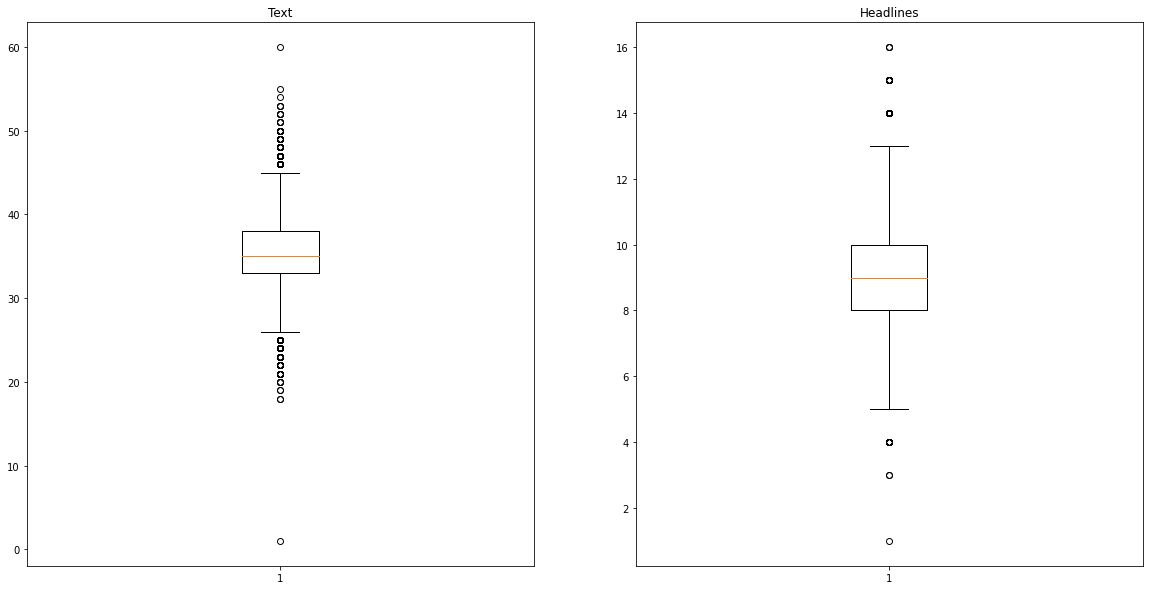

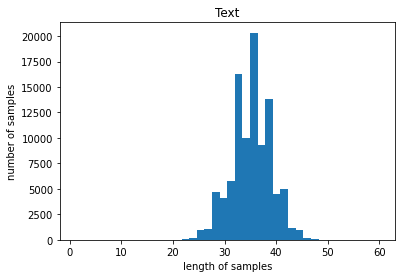

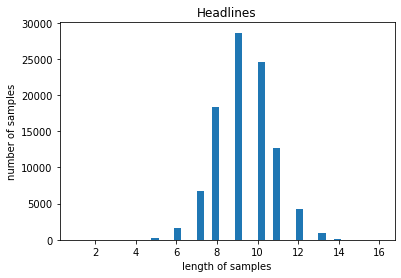

In [18]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['Text']]
headlines_len = [len(s.split()) for s in data['Headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.figure(figsize=(20, 10))
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('Headlines')
# plt.tight_layout()    # subplot들이 겹치지 않도록 최소한의 여백을 만들어 주는 역할 
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 40)            # bins는 계급의 개수
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Headlines')
plt.hist(headlines_len, bins = 40)          # bins는 계급의 개수
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [19]:
# 평균이 각각 35과 9이므로 임의로 적절하다고 생각하는 최대 길이를 선정함
text_max_len = 45
headlines_max_len = 12

각각 50과 8로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될거예요. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼게요.

In [20]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

below_threshold_len(text_max_len, data['Text'])
below_threshold_len(headlines_max_len,  data['Headlines'])

전체 샘플 중 길이가 45 이하인 샘플의 비율: 0.9967771451809678
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880337535583571


각각 40과 11로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 되는데, Text 열의 경우에는 약 1%, Headlines 열의 경우 2%의 샘플들이 내용이 망가지게 된다고 하네요.

우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할게요.

In [21]:
data = data[data['Text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['Headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 96871


## 2.4 시작 토큰과 종료 토큰 추가하기

In [22]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['Headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['Headlines'].apply(lambda x : x + ' eostoken')
data.head()

,Headlines,Text,decoder_input,decoder_target
0,headlines,text,sostoken headlines,headlines eostoken
1,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
3,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
4,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...


In [23]:
# Numpy type으로 저장
encoder_input = np.array(data['Text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

In [24]:
# 확인용
print(encoder_input.shape)

encoder_input[2]

(96871,)


'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit'

## 2.5 훈련 데이터와 데스트 데이터 분리

In [25]:
# 인덱스 번호 shuffle하기
indices = np.arange(encoder_input.shape[0])  # encoder_input 행 개수만큼 연속된 정수 생성
np.random.shuffle(indices)                   # 행 번호를 썪음
print(indices)

[51651 78975 66093 ...  1085 84866 91594]


In [26]:
# 데이터 섞기
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [27]:
# 검증데이터 비율 0.2 설정
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19374


In [28]:
# Train, Test 데이터 분리
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 입력 데이터의 개수 :', len(encoder_input_train))
print('훈련 입력 레이블의 개수 :', len(decoder_input_train))
print('테스트 입력 데이터의 개수 :', len(encoder_input_test))
print('테스트 입력 레이블의 개수 :', len(decoder_input_test))

훈련 입력 데이터의 개수 : 77497
훈련 입력 레이블의 개수 : 77497
테스트 입력 데이터의 개수 : 19374
테스트 입력 레이블의 개수 : 19374


In [29]:
# 확인용
encoder_input_train

array(['astronomers found evidence repeated space radiation called fast radio bursts could coming rapidly rotating neutron stars located near black holes per new publication journal nature sources previously considered signals include exploding stars even beacons alien spaceships frbs discovered australia based parkes telescope',
       'italian skydiver told wife going pull cord going somewhere wonderful minutes jumping death plane said police receiving call wife informed sky dive deland employee radio pilot vitantonio already jumped found dead soon',
       'sri lanka successfully defended runs defeat pakistan runs first test hand pakistan first ever defeat adopted home venue abu dhabi monday sri lanka year old spinner rangana herath became first left arm spinner take wickets picking eleven wickets runs test',
       ...,
       'central government intervene disciplinary cases filed state government ias ips ifs officers ministry personnel told punjab haryana high court centre power r

## 2-6. 단어 집합(vocaburary) 만들기 + 정수 인코딩

### 통계량 확인 함수 정의

In [30]:
def tokenizer_threshold(threshold, tokenizer):
                 
    total_cnt = len(tokenizer.word_index)    # 단어의 수 (v_tokenizer.word_index : {단어 : 단어빈도수가 많은거 순})
    rare_cnt = 0                             # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0                           # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0                            # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1          # 빈도수가 threshold보다 작은 단어의 개수를 카운트
            rare_freq = rare_freq + value    # 빈도수가 threshold보다 작은 단어의 빈도수의 총 합

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print(f"전체 등장 빈도에서 희귀 단어 등장 빈도 비율: {(rare_freq / total_freq):.2%}")

### 1) encoder_input_train

In [31]:
# 단어 집합 생성
src_tokenizer = Tokenizer()                     # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

In [32]:
# 통계량 확인하기
tokenizer_threshold(8, src_tokenizer)

단어 집합(vocabulary)의 크기 : 69068
등장 빈도가 7번 이하인 희귀 단어의 수: 48586
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20482
단어 집합에서 희귀 단어의 비율: 70.34516708171657
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.90%


In [33]:
# 단어 집합 재생성
src_vocab = 20000
src_tokenizer = Tokenizer(num_words = src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train)  # 단어 집합 재생성.

In [34]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3037, 83, 1141, 4360, 311, 4972, 64, 1029, 2805, 11477, 84, 1018, 7255, 10404, 9939, 866, 1739, 374, 590, 4815, 128, 25, 7816, 5750, 3157, 2975, 1042, 1345, 3868, 672, 11478, 866, 206, 10901, 8067, 815, 180, 34, 3251], [1685, 256, 163, 391, 3436, 10405, 391, 7004, 4695, 511, 3418, 179, 967, 1, 9, 1399, 592, 163, 1052, 4403, 11479, 938, 2805, 1204, 673, 2182, 83, 448, 820], [407, 735, 1558, 2888, 282, 1458, 44, 282, 7, 72, 721, 44, 7, 224, 1458, 2565, 135, 3238, 3013, 5806, 62, 407, 735, 3, 13, 913, 19267, 16573, 315, 7, 291, 1486, 913, 107, 701, 4734, 5687, 701, 282, 72]]


### 2) decoder_input_train

In [35]:
# 단어 집합 생성
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train)

In [36]:
# 통계량 확인하기
tokenizer_threshold(6, tar_tokenizer)

단어 집합(vocabulary)의 크기 : 29829
등장 빈도가 5번 이하인 희귀 단어의 수: 19492
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10337
단어 집합에서 희귀 단어의 비율: 65.3458044185189
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.70%


In [37]:
# 단어 집합 재생성
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

#잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 2422, 9466, 172, 7, 3543, 6, 7607, 2382, 5614], [1, 696, 116, 118, 24, 11, 179, 7608, 1092, 3, 92], [1, 899, 3141, 3, 1035, 56, 219, 41, 985, 4, 3628, 7161], [1, 579, 6, 1577, 290, 729, 1187], [1, 2940, 1339, 93, 230, 805, 12, 18, 30, 917, 3142]]
target
decoder  [[2422, 9466, 172, 7, 3543, 6, 7607, 2382, 5614, 2], [696, 116, 118, 24, 11, 179, 7608, 1092, 3, 92, 2], [899, 3141, 3, 1035, 56, 219, 41, 985, 4, 3628, 7161, 2], [579, 6, 1577, 290, 729, 1187, 2], [2940, 1339, 93, 230, 805, 12, 18, 30, 917, 3142, 2]]


## 2.7 eos, sos 토큰은 빈도수가 높아서 매 문장마다 살아있다
요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼게요. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰 각각은 해당 샘플마다 등장하므로 두 토큰의 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한(위 Tokenizer의 num_words 인자)에도 삭제되지 않아요. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 거예요. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 테니까요.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 거예요.

In [38]:
# 각 문장에 eos token 또는 sos token만 있는 경우 인덱스 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 77497
훈련 레이블의 개수 : 77497
테스트 데이터의 개수 : 19374
테스트 레이블의 개수 : 19374


## 2.8 패딩하기
텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 해요

In [39]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = headlines_max_len, padding='post')

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

## 모델 설계하기

In [40]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")

('attention.py', <http.client.HTTPMessage at 0x7f68a14f5790>)

In [41]:
from attention import AttentionLayer
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,)) # text_max_len : 45. 즉 문자의 길이가 45
 
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs) # src_vocab : 20000, 문장의 길이 45인 문장을 넣음

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4) #recurrent_dropout=0
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4) #recurrent_dropout=0
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4) #recurrent_dropout=0
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

# 디코더 입력층
# 디코더 설계, 디코더 인풋 shape 텐서 설정
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2) #recurrent_dropout=0
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c]) 

# 어텐션 층(어텐션 함수)
attn_layer = AttentionLayer(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])  # 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 45)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 45, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 45, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [42]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 50)

Epoch 1/50
303/303 [==============================] - 226s 681ms/step - loss: 5.6187 - val_loss: 5.2065
Epoch 2/50
303/303 [==============================] - 203s 671ms/step - loss: 5.0420 - val_loss: 4.7878
Epoch 3/50
303/303 [==============================] - 204s 672ms/step - loss: 4.6905 - val_loss: 4.5157
Epoch 4/50
303/303 [==============================] - 202s 666ms/step - loss: 4.4242 - val_loss: 4.3237
Epoch 5/50
303/303 [==============================] - 201s 663ms/step - loss: 4.2141 - val_loss: 4.1745
Epoch 6/50
303/303 [==============================] - 200s 661ms/step - loss: 4.0399 - val_loss: 4.0611
Epoch 7/50
303/303 [==============================] - 200s 660ms/step - loss: 3.8937 - val_loss: 3.9780
Epoch 8/50
303/303 [==============================] - 199s 656ms/step - loss: 3.7693 - val_loss: 3.9095
Epoch 9/50
303/303 [==============================] - 200s 659ms/step - loss: 3.6580 - val_loss: 3.8502
Epoch 10/50
303/303 [==============================] - 199s 655m

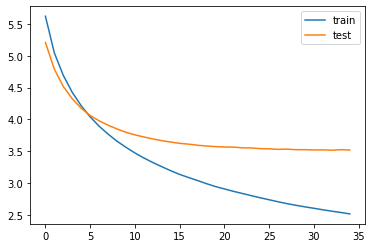

In [43]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 추론(인퍼런스, 예측) 모델 구현하기
테스트 단계에서는 정수 인덱스 행렬로 존재하던 정수 데이터를 실제 단어 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비

In [44]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

seq2seq는 
- **훈련 학습할 때**와 
- **실제 추론(예측)할 때(인퍼런스 단계)**

의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다는 것, 알고 계시나요?

**훈련 단계에**서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 같은 문장인 디코더의 출력과 한 번에 비교하도록 **인코더와 디코더를 엮은 통짜 모델 하나**만 준비했습니다. 즉, 디코더의 입력과 출력값이 이미 존재하는 교사학습처럼 시켰음

그러나  

**정답 문장이 없는 인퍼런스(추론) 단계**에서는 추론해야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 **인코더 모델과 디코더 모델을 분리**해서 설계합니다

In [45]:
# 인코더 모델 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c]) # 각 인자값들은 훈련때 설계한 값들을 들고옴

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,)) # 디코더에 텐서형태로 입력값의 단순한 shape을 지정함
decoder_state_input_c = Input(shape=(hidden_size,)) # 디코더에 텐서형태로 입력값의 단순한 shape을 지정함

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM이 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

어텐션 메커니즘을 사용하는 출력층을 설계

In [46]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

인퍼런스 단계에서 단어 시퀀스를 완성하는 함수를 만들기
## 예측 함수 정의

In [47]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # 에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

## 정수를 텍스트로 변환하는 함수 정의

In [48]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

# Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [49]:
for i in range(50, 100):
    print(f"원문{i} :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문50 : twitter user recently posted picture poll asking people beach door picture shows three colours blue green white placed vertically alongside people got confused initially appears door looks like beach person later shared original photo showing beach 
실제 요약 : beach or door picture goes viral as people get confused 
예측 요약 :  twitter reacts to man shares pic with his own buyback


원문51 : born july serbian inventor nikola tesla moved us work inventor thomas edison tesla quit edison machine works within six months reportedly unpaid bonuses went develop current technology directly challenged edison direct current edison later publicly electrocuted elephant depict ac dangers 
실제 요약 : tesla once worked for his rival thomas edison 
예측 요약 :  apple st apple billionaire to be held in apple


원문52 : yoga guru ramdev patanjali delayed launch kimbho chat app missed official roll date monday announce new date official launch patanjali ayurved managing director acharya balkrishna said tweet app t

예측 요약 :  du schools to hold new name of du students


원문73 : least four workers killed nine injured sunday blast chemical plant gujarat vadodara reports said injured workers two stated critical condition admitted different hospitals treatment cause blast yet known inquiry ordered 
실제 요약 : killed injured in blast at chemical plant in vadodara 
예측 요약 :  killed injured in explosion at explosion in explosion


원문74 : chennai based tvs logistics services private equity firm capital supply chain firm looking acquire vulcan express logistics unit snapdeal crore crore buyout likely take place within next two months report comes snapdeal said talks flipkart potential buyout 
실제 요약 : snapdeal may sell logistics unit for up to crore 
예측 요약 :  reliance industries to buy stake in mumbai reports


원문75 : speaking trend personal branding facebook coo sheryl sandberg said package speak speak honestly data behind think building personal brand career want authentic sandberg added interview psychology pr

예측 요약 :  rbi is like to be used to be ex fm


원문96 : year old woman used name mrs fortune jackpot prize million lottery us woman prize lottery years back prize money takes load comes bills living expenses said 
실제 요약 : woman who won in lottery wins million 
예측 요약 :  woman wins lottery prize for cr


원문97 : us president donald trump branded former fbi director james comey former fbi deputy director andrew losers ruining stellar reputation fbi trump said hurt many great men women fbi trump fired comey last year handling hillary clinton email investigation 
실제 요약 : trump calls comey co for fbi 
예측 요약 :  ex fbi director calls ex fbi director comey


원문98 : video altercation american airlines crew woman carrying child surfaced online airline issued apology deeply sorry pain caused passenger family customers affected airline said notably employee violently took woman hitting 
실제 요약 : airline apologises to woman hit with baby by staff 
예측 요약 :  man who fired woman on flight delays flight dela

In [50]:
seq2text(encoder_input_test[52])

'yoga guru ramdev patanjali delayed launch kimbho chat app missed official roll date monday announce new date official launch patanjali ayurved managing director acharya balkrishna said tweet app taken google play store may day first launched '

In [51]:
str_test = seq2summary(decoder_input_test[52])[:-1]
str_test

'patanjali delays app launch after missing deadline'

# Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높아요. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮아요.

Summa의 summarize를 사용하여 추출적 요약을 해보세요.

## summarize 사용하기
Summa의 summarize()의 인자로 사용되는 값들에 대해서 알아볼게요.
> text (str) : 요약할 테스트.  
ratio (float, optional) – 요약문에서 원본에서 선택되는 문장 비율. 0~1 사이값  
words (int or None, optional) – 출력에 포함할 단어 수.  
만약, ratio와 함께 두 파라미터가 모두 제공되는 경우 ratio는 무시한다.  
split (bool, optional) – True면 문장 list / False는 조인(join)된 문자열을 반환  

Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행해요. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있어요. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여볼게요. 원문의 0.005%만을 출력하도록 설정했어요.

In [53]:
import requests
from summa.summarizer import summarize

In [54]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
summa_data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [55]:
print('Summary:')
print(summarize(summa_data.iloc[36928].text, words=13))

Summary:
Facebook is working on a feature called 'Your Time on Facebook' which will track how much time users spend on an average on the app.


In [62]:
# 여러 개 확인해보기
for idx, (headlines, text) in enumerate(zip(summa_data['headlines'], summa_data['text'])):
    if idx == 20: break
    
    print("원문 :", text)
    print("실제 요약 :", headlines)
    print("예측 요약 :", summarize(text, ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
실제 요약 : upGrad learner switches to career in ML & Al with 90% salary hike
예측 요약 : upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
실제 요약 : Delhi techie wins free food from Swiggy for one year on CRED
예측 요약 : Users get one CRED coin per rupee of bill pai

# Step 6. 추상적 요약과 추출적 요약 비교

In [56]:
print("1)원문(전처리전) :", summa_data.iloc[36928].text)
print("\n")
print("2)원문(전처리후) :", seq2text(encoder_input_test[52]))
print("\n")
print("3)실제 요약 :", seq2summary(decoder_input_test[52]))
print("\n")
print("4)추상적 요약 :", decode_sequence(encoder_input_test[52].reshape(1, text_max_len)))
print("\n")
print("5)추출적 요약 :", summarize(summa_data.iloc[36928].text, ratio=0.5))
print("\n")

1)원문(전처리전) : Facebook is working on a feature called 'Your Time on Facebook' which will track how much time users spend on an average on the app. It will also offer users an option to set a daily time limit to reduce app usage. A company spokesperson confirmed the same but did not reveal when or if the feature would be launched.


2)원문(전처리후) : yoga guru ramdev patanjali delayed launch kimbho chat app missed official roll date monday announce new date official launch patanjali ayurved managing director acharya balkrishna said tweet app taken google play store may day first launched 


3)실제 요약 : patanjali delays app launch after missing deadline 


4)추상적 요약 :  ramdev patanjali to launch app ramdev for ramdev


5)추출적 요약 : Facebook is working on a feature called 'Your Time on Facebook' which will track how much time users spend on an average on the app.




# Step 6. 회고

1. 코드를 이해하는데 시간이 많이 걸렸으며 attention층 구조와 기능을 이해하는데 힘들었다
2. 추론 결과에 대해서 어느 부분은 추론이 잘됐으나 어떤 부분은 문법적으로 오류도 있었다
3. RNN 구조에 대해서 다시 공부해야겠다